In [1]:
pip install lime


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 4.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=3eeda543883ad8ca22db7a89cdc154d25c7f2c6ae5ec8c98fd8795e8cee4e59e
  Stored in directory: /root/.cache/pip/wheels/85/fa/a3/9c2d44c9f3cd77cf4e533b58900b2bf4487f2a17e8ec212a3d
Successfully built lime


In [2]:
pip install pyoselm

  Preparing metadata (setup.py) ... done
Discarding https://files.pythonhosted.org/packages/56/c6/0914a51aea89064725cec9b9ad92adb77d8ae6b03dd369b00641369aae79/pyoselm-1.0.1-2.tar.gz (from https://pypi.org/simple/pyoselm/): Requested pyoselm from https://files.pythonhosted.org/packages/56/c6/0914a51aea89064725cec9b9ad92adb77d8ae6b03dd369b00641369aae79/pyoselm-1.0.1-2.tar.gz has inconsistent version: expected '1.0.1.post2', but metadata has '1.0.1'



📘 X_train_scaled:
        BVP       EDA      TEMP         X         Y         Z        HR  \
0 -0.471120 -0.659270  0.258455 -0.002032 -0.605395  0.756258 -0.807135   
1 -0.087365 -0.674260  0.050494 -1.164615 -0.097261 -0.545259 -0.538412   
2  0.013315  0.858887  1.228937  0.742022  0.254524  1.123352  1.098095   
3  0.212290 -0.700028 -0.189460  0.369995 -1.973448 -0.311654 -0.915398   
4  0.038024  0.059074  0.290449  1.579082  1.153531  1.023235 -0.364418   

      Delta     Theta    Alpha1    Alpha2     Beta1     Beta2    Gamma1  \
0  1.699961 -0.688622  1.249073 -0.587974 -0.725217  0.883266 -0.709403   
1  0.390992 -0.660252 -0.725355 -0.263095 -0.722949 -0.711458 -0.475862   
2 -0.690126 -0.683329 -0.127544 -0.660055  0.054753  0.033733 -0.605752   
3  2.078938 -0.286534  1.287965  1.230047  0.011405  1.768263 -0.673554   
4  0.645086  0.776228 -0.691491  1.234611  1.320024  1.267352 -0.716893   

     Gamma2  Attention  Meditation  
0  2.532636   1.287393   -0.667867  
1 -0.

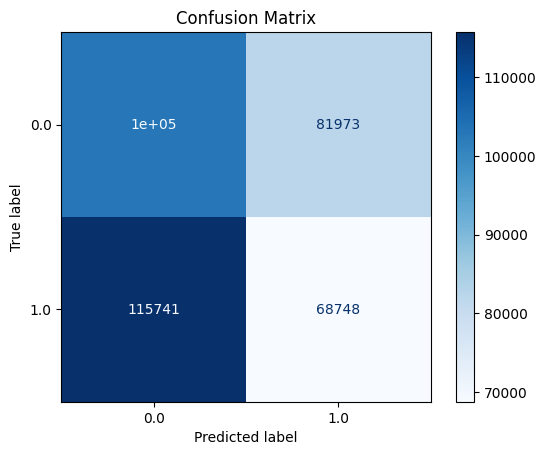

   Sample  Predicted_Class  Uncertainty (1 - max prob)
0       0              0.0                    0.489817
1       1              1.0                    0.375305
2       2              0.0                    0.411500
3       3              0.0                    0.335522
4       4              0.0                    0.445835


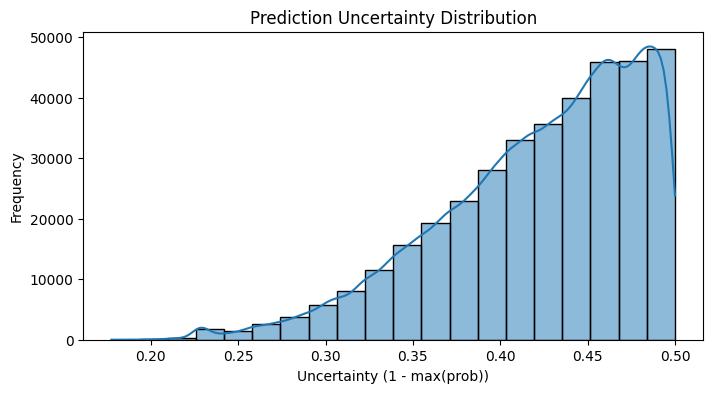

 99%|===================| 198/200 [00:26<00:00]       

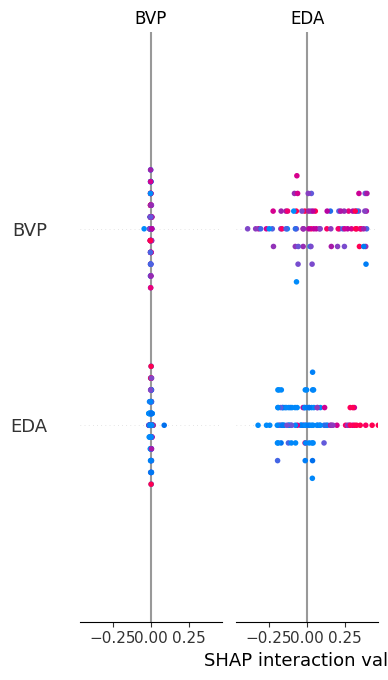


🟡 LIME Explanation for First Sample:
[('TEMP > 0.75', 0.12437148857760402), ('-0.65 < EDA <= -0.43', -0.09090875482770161), ('HR > 0.58', -0.08510263654544988), ('Y <= -0.53', 0.04421526103277298), ('Gamma1 <= -0.65', -0.011268289799922868), ('Theta <= -0.62', 0.010541119917452626), ('-0.39 < Beta1 <= 0.26', -0.010249712330610356), ('-0.66 < Alpha1 <= -0.37', 0.007671134190822001), ('-0.14 < X <= 0.56', -0.006362853400226422), ('-0.87 < Meditation <= 0.02', 0.005741554204674683)]

✅ Results saved to 'OSELM_Model_Results.xlsx'


In [4]:
# oselm_uncertainty_xai.py

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shap
from lime.lime_tabular import LimeTabularExplainer

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    matthews_corrcoef, confusion_matrix, classification_report,
    ConfusionMatrixDisplay
)

from scipy.special import softmax
from scipy.linalg import pinv
from sklearn.utils.extmath import safe_sparse_dot
from sklearn.preprocessing import LabelBinarizer
from sklearn.utils import as_float_array

import warnings
warnings.filterwarnings("ignore")


class SimpleRandomLayer:
    def __init__(self, n_hidden=100, activation_func="sigmoid", random_state=None):
        self.n_hidden = n_hidden
        self.activation_func = activation_func
        self.random_state = np.random.RandomState(random_state)

    def _sigmoid(self, x):
        return 1 / (1 + np.exp(-x))

    def fit_transform(self, X):
        self.input_weights = self.random_state.uniform(-1., 1., (X.shape[1], self.n_hidden))
        self.biases = self.random_state.uniform(-1., 1., (self.n_hidden,))
        H = X @ self.input_weights + self.biases
        return self._sigmoid(H)


class OSELMClassifier:
    def __init__(self, n_hidden=100, activation_func="sigmoid", random_state=0):
        self.n_hidden = n_hidden
        self.activation_func = activation_func
        self.random_state = random_state
        self.layer = SimpleRandomLayer(n_hidden, activation_func, random_state)
        self.binarizer = LabelBinarizer(neg_label=0, pos_label=1)
        self.beta = None
        self.P = None
        self.classes_ = None # Initialize classes_ attribute


    def fit(self, X, y):
        y_bin = self.binarizer.fit_transform(y)
        self.classes_ = self.binarizer.classes_ # Store the classes
        H = self.layer.fit_transform(X)
        self.P = pinv(H.T @ H)
        self.beta = self.P @ H.T @ y_bin
        return self

    def predict(self, X):
        H = self.layer.fit_transform(X)
        output = H @ self.beta
        return self.binarizer.inverse_transform(output)

    def predict_proba(self, X):
        H = self.layer.fit_transform(X)
        raw_output = H @ self.beta

        # Ensure raw_output is at least 2D, even for binary classification
        if raw_output.ndim == 1:
            raw_output = raw_output.reshape(-1, 1)

        # For binary classification with LabelBinarizer, raw_output will have shape (n_samples, 1).
        # We need to manually create the probabilities for both classes.
        if len(self.classes_) == 2 and raw_output.shape[1] == 1:
             # Assuming the single column is the probability of the positive class (class_[1])
            prob_positive = raw_output
            prob_negative = 1 - prob_positive
            raw_output = np.hstack((prob_negative, prob_positive))


        return softmax(raw_output, axis=1)


def compute_uncertainty(probs):
    return 1 - np.max(probs, axis=1)


def main():
    data = pd.read_csv("/content/drive/MyDrive/CODE/Prince Okyere/UP/MEFAR_UP.csv")
    data.dropna(inplace=True)
    label_encoder = LabelEncoder()
    data['class'] = label_encoder.fit_transform(data['class'])
    classes = label_encoder.classes_.astype(str)

    X = data.drop('class', axis=1)
    y = data['class']

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)


    oselm = OSELMClassifier(n_hidden=100, activation_func="sigmoid", random_state=0)
    oselm.fit(X_train_scaled, y_train)
    y_pred_class = oselm.predict(X_test_scaled)
    y_pred_prob = oselm.predict_proba(X_test_scaled)

    # Convert to DataFrames for better display
    X_train_df = pd.DataFrame(X_train_scaled, columns=X.columns)
    X_test_df = pd.DataFrame(X_test_scaled, columns=X.columns)
    y_pred_class_df = pd.DataFrame({"Predicted Class": label_encoder.inverse_transform(y_pred_class)}) # Inverse transform here
    y_pred_prob_df = pd.DataFrame(y_pred_prob, columns=[f"Class_{cls}" for cls in label_encoder.classes_])

    # Display them
    print("\n📘 X_train_scaled:")
    print(X_train_df.head())

    print("\n📗 X_test_scaled:")
    print(X_test_df.head())

    print("\n📙 Predicted Classes:")
    print(y_pred_class_df.head())

    print("\n📕 Predicted Probabilities:")
    print(y_pred_prob_df.head())



    acc = accuracy_score(y_test, y_pred_class)
    prec = precision_score(y_test, y_pred_class, average='weighted')
    rec = recall_score(y_test, y_pred_class, average='weighted')
    f1 = f1_score(y_test, y_pred_class, average='weighted')
    mcc = matthews_corrcoef(y_test, y_pred_class)
    report = classification_report(y_test, y_pred_class, target_names=classes)
    cm = confusion_matrix(y_test, y_pred_class)

    print("\n📊 Classification Report:\n", report)

    youden_index = np.nan
    if cm.shape == (2, 2):
        tn, fp, fn, tp = cm.ravel()
        specificity = tn / (tn + fp)
        sensitivity = recall_score(y_test, y_pred_class)
        youden_index = sensitivity + specificity - 1

    ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes).plot(cmap='Blues')
    plt.title("Confusion Matrix")
    plt.show()

    uncertainties = compute_uncertainty(y_pred_prob)
    uncertainty_df = pd.DataFrame({
        "Sample": np.arange(len(uncertainties)),
        "Predicted_Class": label_encoder.inverse_transform(y_pred_class),
        "Uncertainty (1 - max prob)": uncertainties
    })
    print(uncertainty_df.head())

    plt.figure(figsize=(8, 4))
    sns.histplot(uncertainties, bins=20, kde=True)
    plt.title("Prediction Uncertainty Distribution")
    plt.xlabel("Uncertainty (1 - max(prob))")
    plt.ylabel("Frequency")
    plt.show()

    rf = RandomForestClassifier()
    rf.fit(X_train_scaled, y_train)

    explainer = shap.Explainer(rf, X_train_scaled)
    shap_values = explainer(X_test_scaled[:100])
    shap.summary_plot(shap_values, X_test.iloc[:100], show=True)

    lime_exp = LimeTabularExplainer(X_train_scaled, feature_names=X.columns,
                                    class_names=classes, discretize_continuous=True)
    lime_result = lime_exp.explain_instance(X_test_scaled[0], rf.predict_proba, num_features=10)
    print("\n🟡 LIME Explanation for First Sample:")
    print(lime_result.as_list())

    results_df = pd.DataFrame({
        "Metric": ["Accuracy", "Precision", "Recall", "F1 Score", "MCC", "Youden Index"],
        "Value": [acc, prec, rec, f1, mcc, youden_index]
    })
    results_df.to_excel("OSELM_Model_Results.xlsx", index=False)
    print("\n✅ Results saved to 'OSELM_Model_Results.xlsx'")


if __name__ == "__main__":
    main()